# SVMM: Pap Smear Slides Clustering

## Questions

Can we use unlabelled images from pap smear tests to classify cells as abnormal/normal cells?

Can we determine the correct cell types using unlabelled images?

## Methodology

1. Data Understanding
2. Data exploration
3. Data preparation
4. Autoencoder
5. K-means clustering
6. Making predictions

## The Data

The dataset was obtained from kaggle. The [pap smear dataset](http://www.kaggle.com/umangjpatel/pap-smear-datasets) is a collection of microscopy images of samples collected from pap smears. 

The data consists of labelled images in three forms: the Herlev dataset, a single cell dataset, and a whole-slides dataset. The single cell dataset will be used for this analysis since it has the clearest images.

The data is sufficient and relevant to answer the questions above.

## Metrics for success

The analysis will be successful if the model can cluster images correctly according to cell type and normal/abnormal states with very few false-negatives. 

A false negative here would be disastrous since early detection and treatment has an impact on cancer survival rates.

## Data exploration

In [1]:
# Loading the required libraries

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


In [2]:
# Loading image files and labels

import glob
from skimage.transform import resize

images = []   
labels = []
    
sipakmed_fci_image_path = '../input/pap-smear-datasets/sipakmed_fci_pap_smear/' # images
sub_directories = os.listdir(sipakmed_fci_image_path) # labels

# Summarizing cell types in the data
for sub_dir in sub_directories:
    dir_image_path = sipakmed_fci_image_path + sub_dir
    
    print("\nDIRECTORY: ",sub_dir)    
    total_file_count = os.listdir(dir_image_path)
    print("\nTotal_files: ", len(total_file_count))

    bmp_paths= glob.glob(dir_image_path+'/*.bmp') # The actual images of slides
    print("\nBmp_files: ", len(bmp_paths))

for sub_dir in sub_directories:
    for file in bmp_paths:
        image = mpimg.imread(file)
        image = resize(image, (100, 140))
        images.append(np.array(image))
        labels.append(sub_dir)
return images, labels



DIRECTORY:  abnormal_Koilocytotic

Total_files:  2475

Bmp_files:  825

DIRECTORY:  abnormal_Dyskeratotic

Total_files:  2439

Bmp_files:  813

DIRECTORY:  normal_Parabasal

Total_files:  2361

Bmp_files:  787

DIRECTORY:  normal_Superficial_Intermediate

Total_files:  2493

Bmp_files:  831

DIRECTORY:  benign_Metaplastic

Total_files:  2379

Bmp_files:  793


SyntaxError: 'return' outside function (<ipython-input-2-dbfe3466c38f>, line 29)

In [3]:
# Storing the mages as an array
ps = np.asarray(images)
print(ps.shape)

(3965, 100, 140, 3)


In [4]:
# Storing labels in an array
lb = (np.asarray(labels))
print(lb.shape)

#Previewing the labels
lb[1:3900:600]

(3965,)


array(['abnormal_Koilocytotic', 'abnormal_Koilocytotic',
       'abnormal_Dyskeratotic', 'normal_Parabasal',
       'normal_Superficial_Intermediate',
       'normal_Superficial_Intermediate', 'benign_Metaplastic'],
      dtype='<U31')

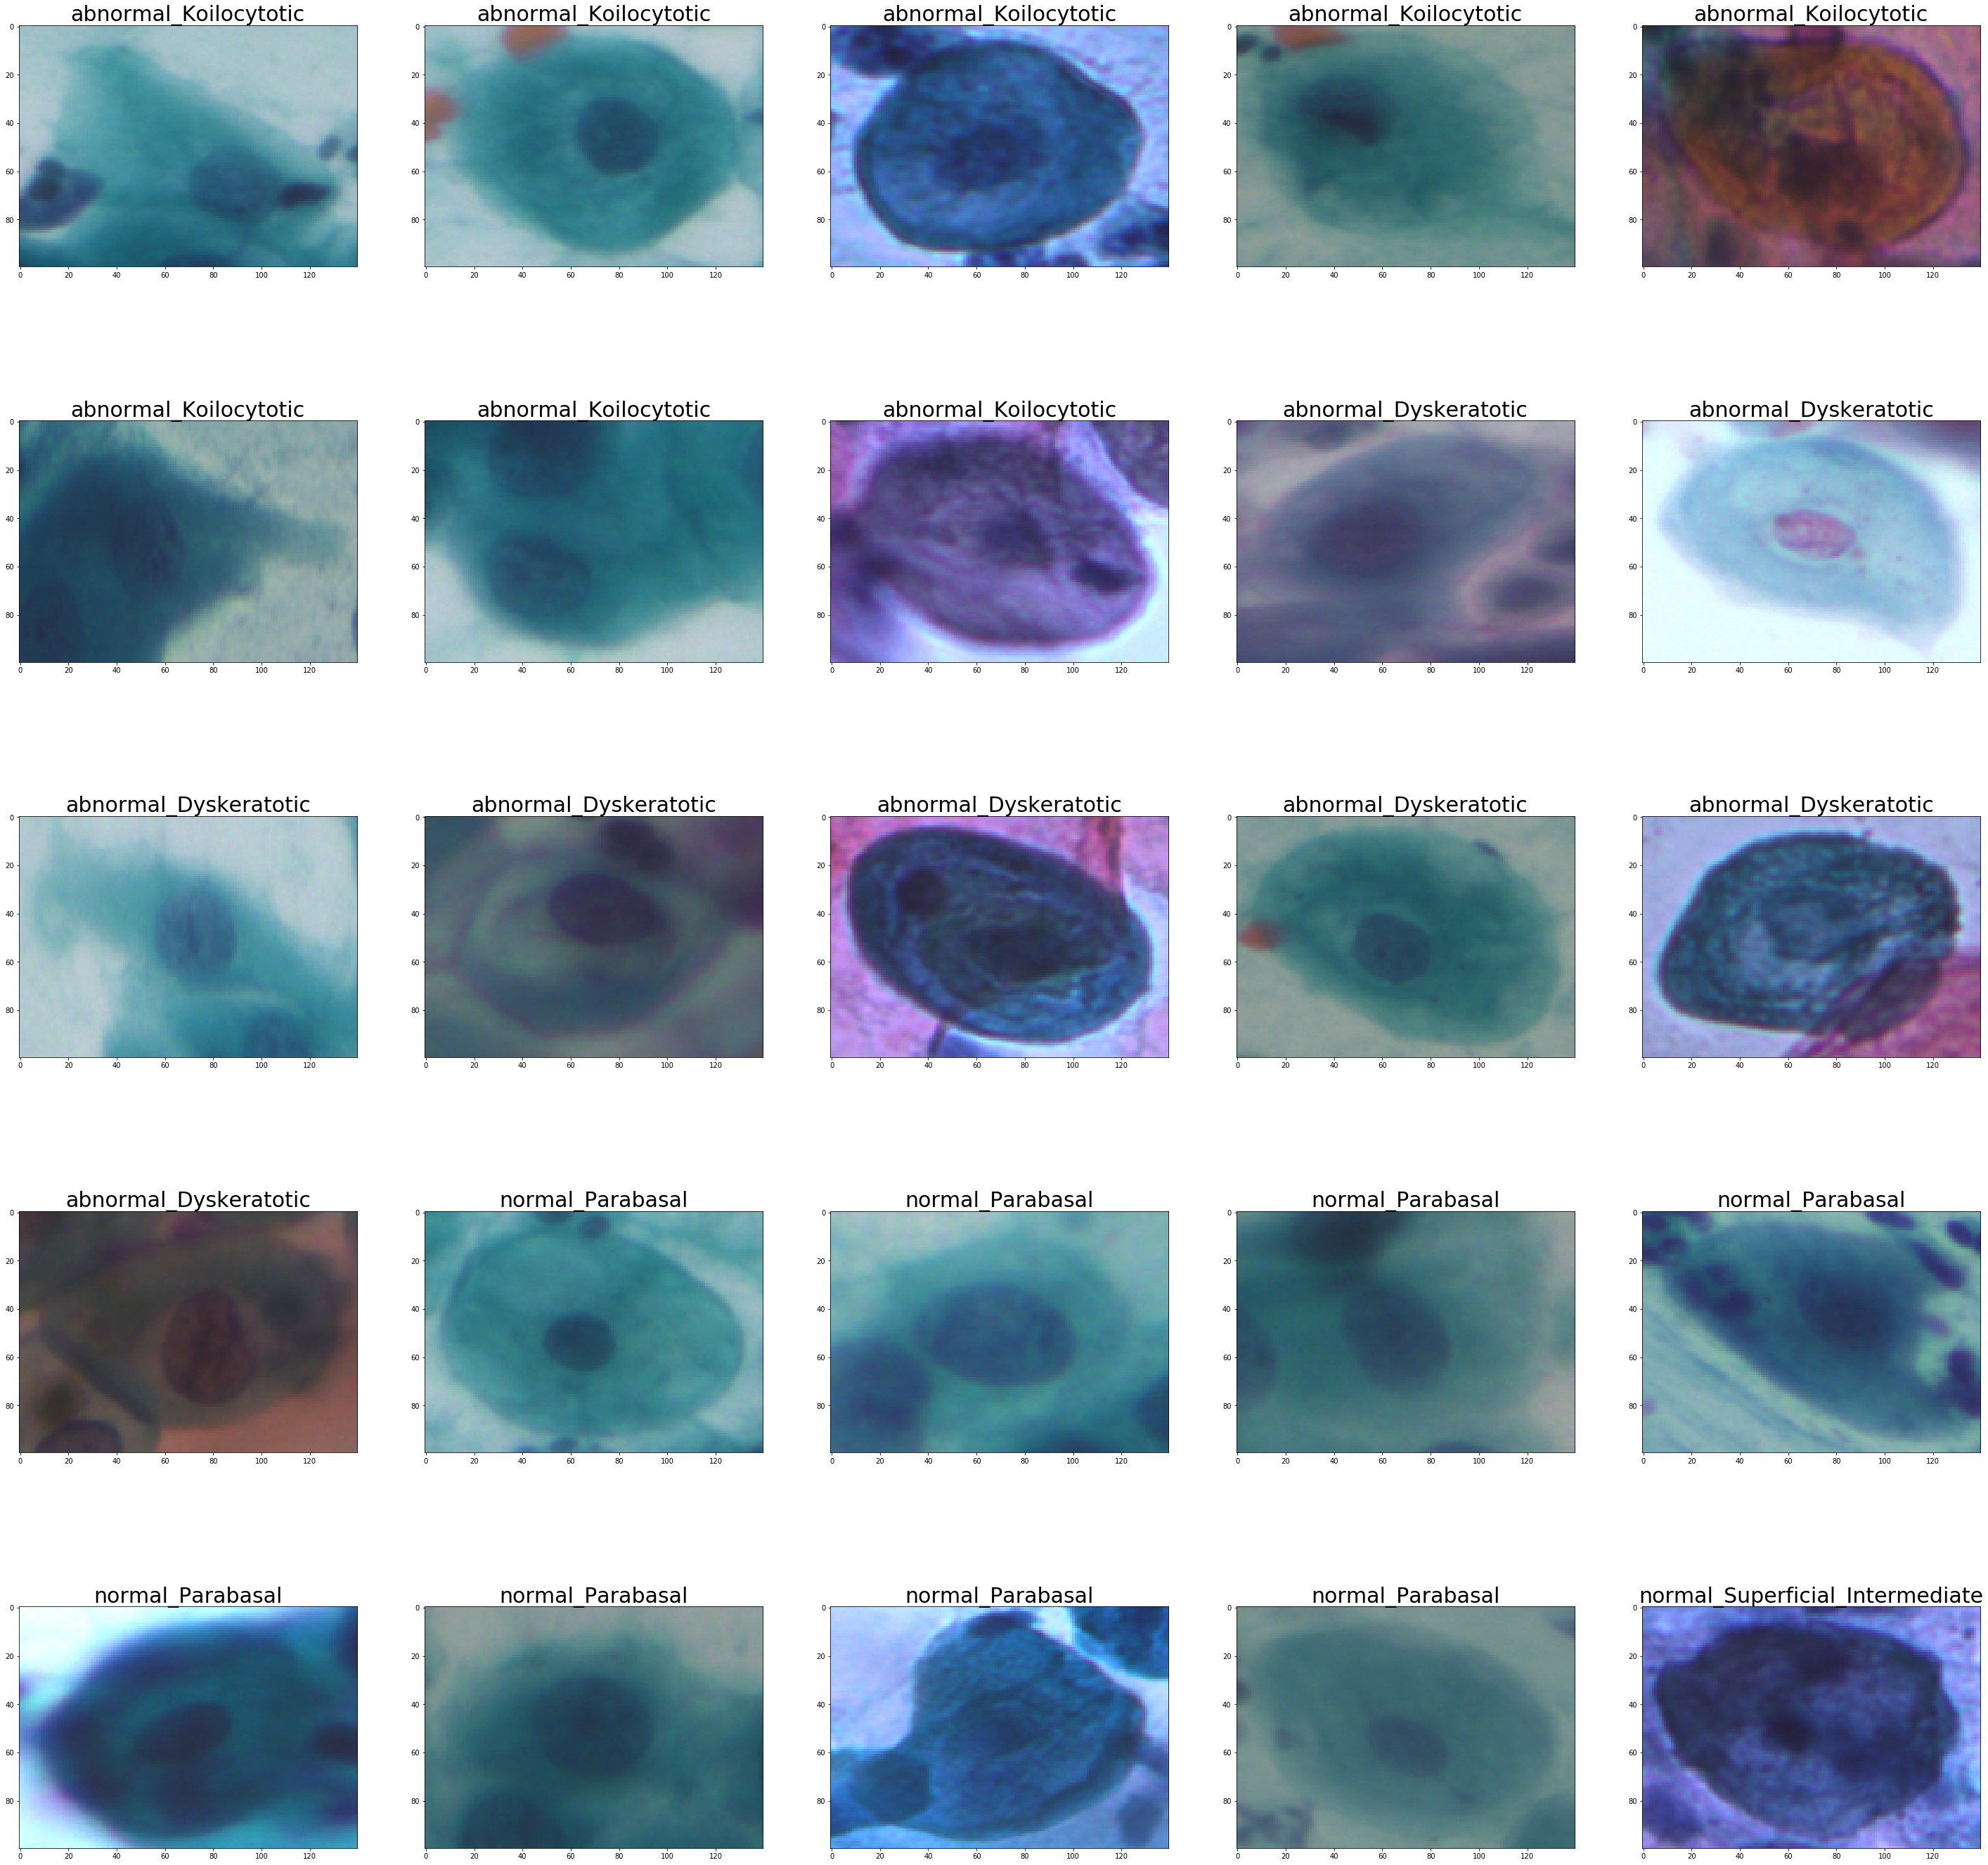

In [5]:
# Previewing some images
sample = ps[1:3960:100]
samp_lab = lb[1:3960:100]

fig, axes = plt.subplots(5,5, figsize=(50,50))
for i,ax in enumerate(axes.flat):
    ax.imshow(sample[i])
    ax.set_title(samp_lab[i], fontsize = 30)


## Modelling

In [6]:
# Defining variables for modelling
X = ps
y = lb

# Splitting data into train, test, validate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

### Autoencoder

In [7]:
# Building the autoencoder
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu', input_shape=(100,140,3)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(3, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 140, 14)      392       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 70, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 70, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 70, 7)         889       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 35, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 35, 7)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 35, 7)        

In [8]:
# Training the model
model.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_validate, X_validate), verbose=1)

Train on 2379 samples, validate on 793 samples
Epoch 1/50
2379/2379 [==============================] - 7s 3ms/step - loss: 0.1117 - val_loss: 0.0321
Epoch 2/50
2379/2379 [==============================] - 2s 844us/step - loss: 0.0317 - val_loss: 0.0460
Epoch 3/50
2379/2379 [==============================] - 2s 922us/step - loss: 0.0197 - val_loss: 0.0369
Epoch 4/50
2379/2379 [==============================] - 2s 922us/step - loss: 0.0141 - val_loss: 0.0316
Epoch 5/50
2379/2379 [==============================] - 2s 923us/step - loss: 0.0118 - val_loss: 0.0255
Epoch 6/50
2379/2379 [==============================] - 2s 911us/step - loss: 0.0105 - val_loss: 0.0175
Epoch 7/50
2379/2379 [==============================] - 2s 935us/step - loss: 0.0096 - val_loss: 0.0151
Epoch 8/50
2379/2379 [==============================] - 2s 924us/step - loss: 0.0088 - val_loss: 0.0127
Epoch 9/50
2379/2379 [==============================] - 2s 930us/step - loss: 0.0083 - val_loss: 0.0119
Epoch 10/50
2379/23

In [9]:
# Making predictions using the testing dataset
restored_testing_dataset = model.predict(X_test)

In [10]:
# Extracting the encoder
encoder = K.function([model.layers[0].input], [model.layers[4].output])

In [11]:
# Encoding the training images
encoded_images = encoder([X_test])[0].reshape(-1, 25*35*7)

### K-means Clustering

In [12]:
# K-means: clustering the encoded images
kmeans = KMeans(n_clusters=5)
clustered_training_set = kmeans.fit_predict(encoded_images)

In [13]:
# Changing labels to categorical values
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

y_test2  = encoder.fit_transform(y_test)

# Category labels after encoding
print('Original label:', y_test[500])
print('After conversion to one-hot:', y_test2[500])


Original label: benign_Metaplastic
After conversion to one-hot: 2


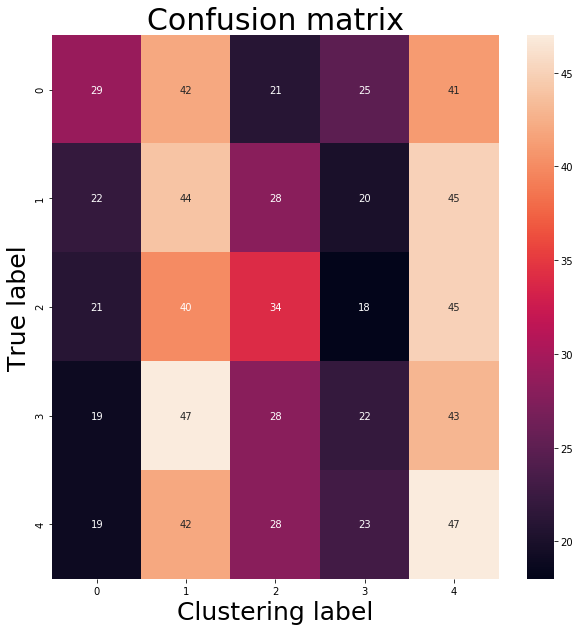

In [14]:
# Comparing clustering result with actual label using confusion matrix
cm = confusion_matrix(y_test2.astype(int), clustered_training_set.astype(int))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

Text(0.5, 1.0, 'True Labels')

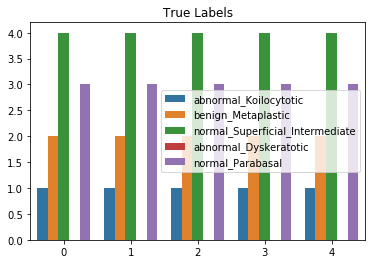

In [15]:
# Plotting labels
sns.barplot(clustered_training_set, y_test2, hue=y_test)
plt.title("True Labels")

Text(0.5, 1.0, 'True Labels')

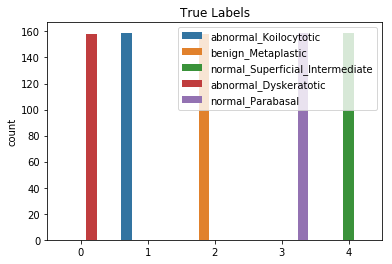

In [16]:
# Plotting test data with labels
sns.countplot(y_test2, hue=y_test)
plt.title("True Labels")

Text(0.5, 1.0, 'Clusters')

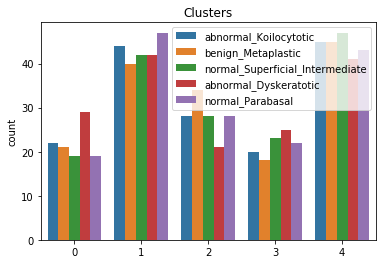

In [17]:
# Plotting clusters vs labels
sns.countplot(clustered_training_set, hue=y_test)
plt.title("Clusters")